In [1]:
%config InlineBackend.figure_format = 'retina'

%config IPCompleter.use_jedi = False
import multiprocessing.popen_spawn_posix

import os
import numpy as np
import pandas as pd
import dask
import dask.dataframe as dd

from daskdecorators import dask_hist, profile_plot

from hist import Hist
import mplhep as hep

from functools import reduce
import treecorr

import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['savefig.dpi'] = 120
matplotlib.rcParams['figure.dpi'] = 120

In [3]:
from dask.distributed import Client, LocalCluster

#cluster = LocalCluster(n_workers=8, 
#                       threads_per_worker=1,
#                       memory_limit='6Gb')
#client = Client(cluster)

dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"
client = Client(scheduler_file='/global/cscratch1/sd/cwalter/scheduler.json')

client

Client Scheduler: tcp://10.128.0.90:43615 Dashboard: /user/cwalter/cori-shared-node-cpu/proxy/10.128.0.90:44183/status,Cluster Workers: 159 Cores: 159 Memory: 2.52 TB


In [4]:
from scipy.special import comb

scratch= os.environ["SCRATCH"]
#scratch = '/Users/walter/LSST/work'

selected = ['id', 'mag_r', 'z', 'ra', 'dec', 'g1', 'g2']

df = dd.read_parquet(f'{scratch}/parquet-skysim/*.parquet', columns=selected, engine='pyarrow')
#df = dd.read_parquet(f'{scratch}/skysim-sampled', columns=selected, engine='pyarrow')
df = df.persist()

number_in_df = df.index.size.compute()
print('Columns:', df.columns.values, '#Rows:', number_in_df/1e9)
print(f'There are {number_in_df:,d} elements in the area with {comb(number_in_df, 2, exact=True):,d} total combinations')

Columns: ['id' 'mag_r' 'z' 'ra' 'dec' 'g1' 'g2'] #Rows: 6.263019986
There are 6,263,019,986 elements in the area with 19,612,709,669,386,210,105 total combinations


ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x2aaaee845a90>, cbar=<matplotlib.colorbar.Colorbar object at 0x2aaadf36dd10>)

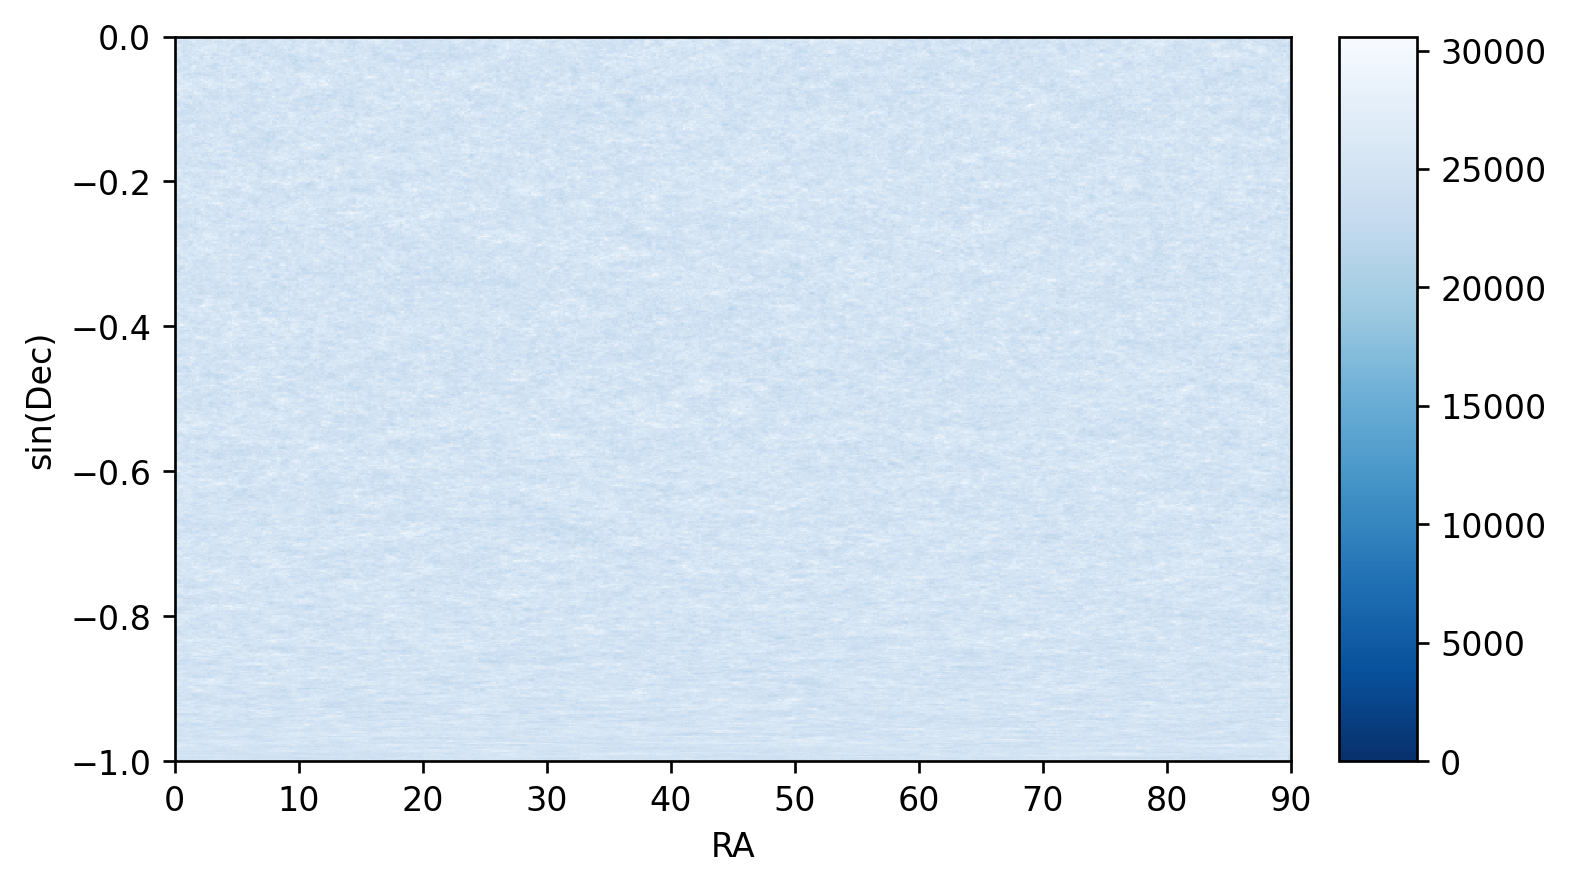

In [5]:
@dask_hist
def dask_survey(df):

    from scipy.special import sindg as sindg
    
    h = Hist.new.Reg(500, 0, 90, name='RA').Reg(500, sindg(-90), sindg(0), name='Dec', label='sin(Dec)').Double()
    h.fill(df.ra, sindg(df.dec))
    return h

heatmap = dask_survey(df)
heatmap.plot2d(cmap='Blues_r', vmin=0)

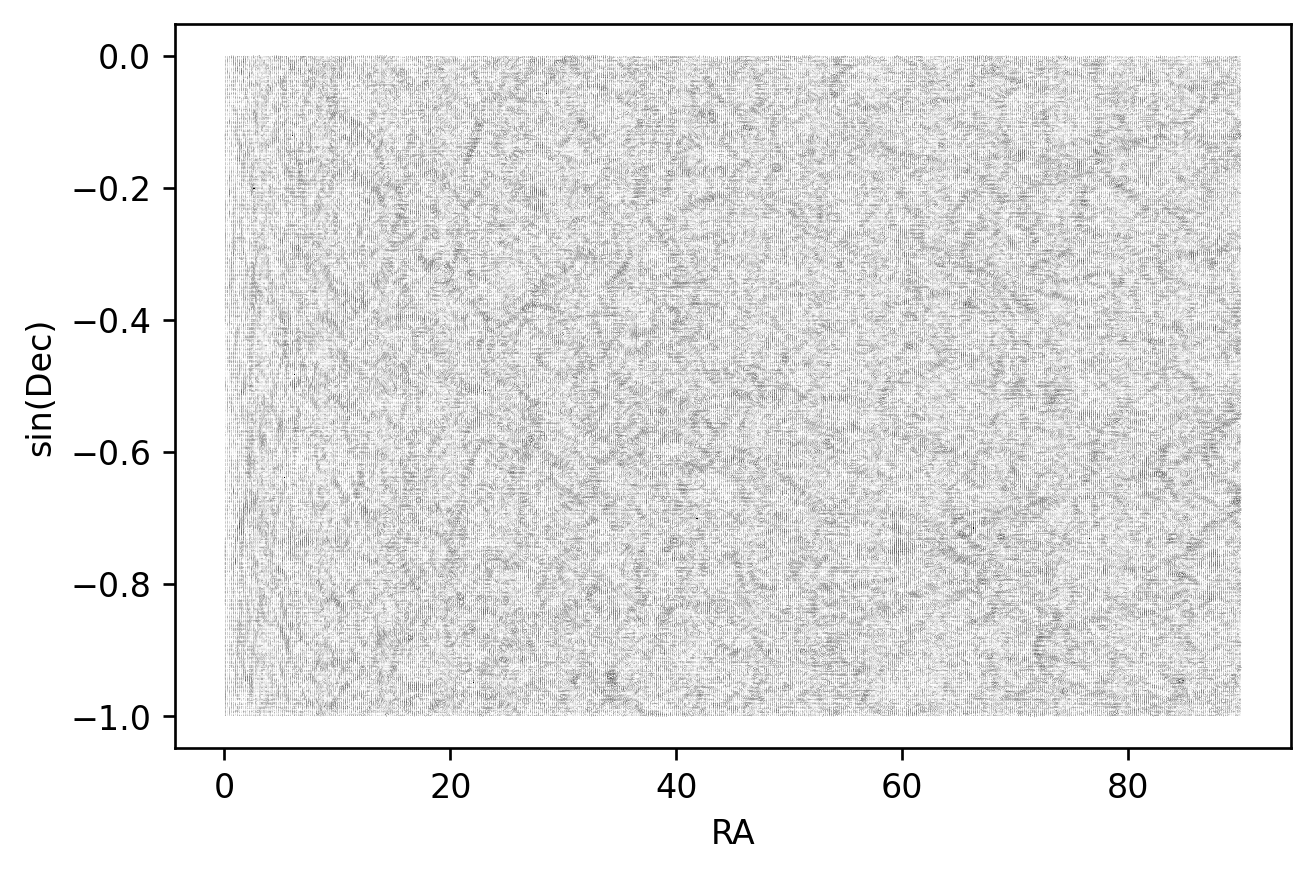

In [6]:
binning = 500

@dask_hist
def mean_g1_equal(df):
    
    from scipy.special import sindg as sindg
    
    h = Hist.new.Reg(binning, 0, 90, name='RA').Reg(binning, sindg(-90), sindg(0), name='Dec').Mean()
    h.fill(df.ra, sindg(df.dec), sample=df.g1)
    return h

@dask_hist
def mean_g2_equal(df):
    
    from scipy.special import sindg as sindg
    
    h = Hist.new.Reg(binning, 0, 90, name='RA').Reg(binning, sindg(-90), sindg(0), name='Dec').Mean()
    h.fill(df.ra, sindg(df.dec), sample=df.g2)
    return h

g1_hist = mean_g1_equal(df)
g2_hist = mean_g2_equal(df)

x_centers = g1_hist.axes[0].centers
y_centers = g1_hist.axes[1].centers

g1 = g1_hist.view().value
g2 = -g2_hist.view().value

reduced_shear = g1 + g2*1j
magnitude = np.abs(reduced_shear)
phi = np.angle(reduced_shear)/2

plt.quiver(x_centers, y_centers, magnitude*np.cos(phi), magnitude*np.sin(phi), pivot='mid', 
           headaxislength=0, headlength=0, headwidth=0, width=.0003)
plt.xlabel('RA')
plt.ylabel('sin(Dec)');

Fitted value 
0.000192 +- 0.000002 
0.000365 +- 0.000003 
0.000209 +- 0.000009 
Chi2: 1777.01


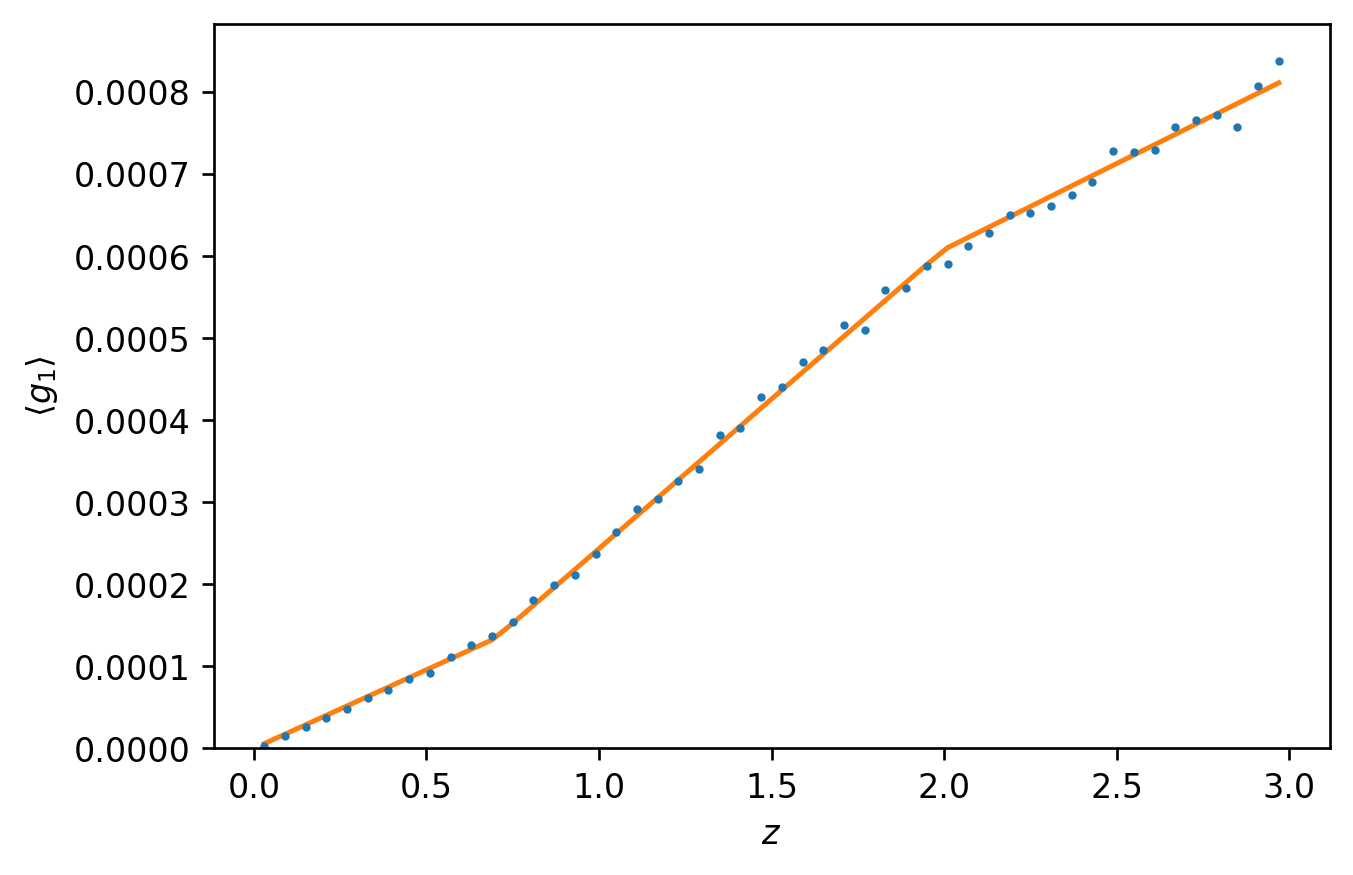

In [11]:
from scipy.optimize import curve_fit

@dask_hist
def g1_z_prof(df):

    h = Hist.new.Reg(50, 0, 3).Mean()
    h.fill(df.z, sample=df.g1)
    return h

def new_slope(x, slope1, slope2, slope3):
    
    break_1, break_2 = .7, 2

    y = np.piecewise(x, [x <= break_1, (x > break_1)&(x <= break_2), (x > break_2)], 
                     [lambda x:slope1*x, 
                      lambda x:slope2*(x - break_1) + break_1*slope1, 
                      lambda x:slope3*(x - break_2) + break_1*slope1 + (break_2-break_1)*slope2])
    return y

h = g1_z_prof(df)
centers = h.axes.centers[0]
mean = h.view().value
error_on_mean = np.sqrt(h.view().variance/h.view().count)

popt, pcov = curve_fit(new_slope, centers, mean, sigma=error_on_mean)
print(f'Fitted value',
      f'\n{popt[0]:0.6f} +- {np.sqrt(pcov[0][0]):.6f}',
      f'\n{popt[1]:0.6f} +- {np.sqrt(pcov[1][1]):.6f}',
      f'\n{popt[2]:0.6f} +- {np.sqrt(pcov[2][2]):.6f}',
      f'\nChi2: {sum(((mean-new_slope(centers, *popt))/error_on_mean)**2):4.2f}')

plt.errorbar(centers, mean, yerr=error_on_mean, fmt = '.', markersize=3)
plt.plot(centers, new_slope(centers, *popt))

plt.ylim(bottom=0)
plt.xlabel(r'$z$')
plt.ylabel(r'$\langle g_1 \rangle$');

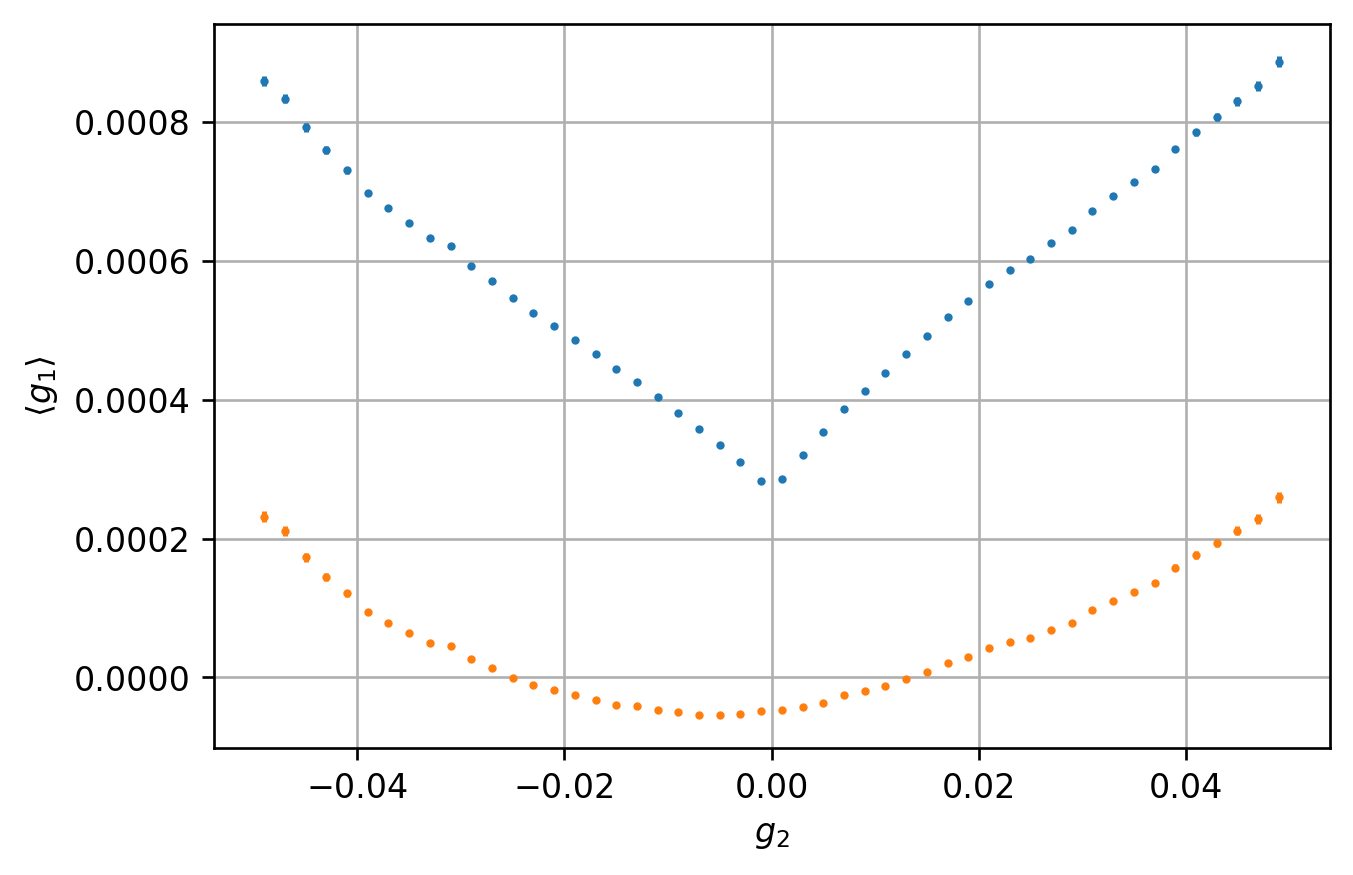

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [12]:
@profile_plot
@dask_hist
def hist_g1_prof(df):

    h = Hist.new.Reg(50, -0.05, 0.05).Mean()
    h.fill(df.g2, sample=df.g1)
    return h

@profile_plot
@dask_hist
def hist_g1prime_prof(df):

    h = Hist.new.Reg(50, -0.05, 0.05).Mean()
    h.fill(df.g2, sample=df.g1_prime)
    return h

df['g1_prime'] = df.g1 - new_slope(df.z.to_dask_array(), *popt)

hist_g1_prof(df)
hist_g1prime_prof(df)

plt.grid(True)
plt.xlabel(r'$g_2$')
plt.ylabel(r'$\langle g_1 \rangle$');

In [13]:
df['g1_prime'] = df.g1 - new_slope(df.z.to_dask_array(), *popt)
selected = df.query('z>0.0')

def treecorr_chunk(dataframe):
    
    cat = treecorr.Catalog(ra=dataframe.ra, dec=dataframe.dec, g1=dataframe.g1, g2=dataframe.g2, flip_g2=True, ra_units='deg', dec_units='deg')

    gg = treecorr.GGCorrelation(min_sep=1., max_sep=200., nbins=20, num_threads=1, sep_units='arcmin')
    gg.process_auto(cat)
    return gg, cat.varg*cat.sumw, cat.sumw

result = selected.map_partitions(treecorr_chunk)

def treecorr_chunk_prime(dataframe):
    
    cat = treecorr.Catalog(ra=dataframe.ra, dec=dataframe.dec, g1=dataframe.g1_prime, g2=dataframe.g2, flip_g2=True, ra_units='deg', dec_units='deg')

    gg = treecorr.GGCorrelation(min_sep=1., max_sep=200., nbins=20, num_threads=1, sep_units='arcmin')
    gg.process_auto(cat)
    return gg, cat.varg*cat.sumw, cat.sumw

result_prime = selected.map_partitions(treecorr_chunk_prime)

In [ ]:
computed = result.compute()
result_gg, result_varg, result_sum = list(zip(*computed))

gg = reduce(treecorr.GGCorrelation.__iadd__, result_gg)
varg = sum(result_varg)/sum(result_sum)

gg.finalize(varg, varg)

computed_prime = result_prime.compute()
result_gg_prime, result_varg_prime, result_sum_prime = list(zip(*computed_prime))

gg_prime = reduce(treecorr.GGCorrelation.__iadd__, result_gg_prime)
varg_prime = sum(result_varg_prime)/sum(result_sum_prime)

gg_prime.finalize(varg_prime, varg_prime)

In [ ]:
bins = np.append(gg.left_edges, gg.right_edges[-1])
xip, xim = gg.xip, gg.xim
sigma_p, sigma_m = np.sqrt(gg.varxip), np.sqrt(gg.varxip)

xip_prime, xim_prime = gg_prime.xip, gg_prime.xim
sigma_p_prime, sigma_m_prime = np.sqrt(gg_prime.varxip), np.sqrt(gg_prime.varxip)

hep.histplot(xip, bins=bins, yerr=sigma_p, histtype='errorbar', markersize=6, label=r'$\xi_+$')
hep.histplot(xim, bins=bins, yerr=sigma_m, histtype='errorbar', markersize=6, label=r'$\xi_-$')
hep.histplot(xip_prime, bins=bins, yerr=sigma_p, histtype='errorbar', linestyle=':', marker='', label=r'$\xi^{\prime}_+$')
hep.histplot(xim_prime, bins=bins, yerr=sigma_m, histtype='errorbar', linestyle=':', marker='', label=r'$\xi^{\prime}_-$')

plt.xscale('log')
#plt.yscale('log')
#plt.ylim(bottom=0.5e-6)
plt.legend()
plt.ylabel(r'$\xi$')
plt.xlabel(r'$\theta$ (arcmin)');

In [ ]:
gg = treecorr.GGCorrelation(min_sep=1., max_sep=200., nbins=20, num_threads=1, sep_units='arcmin')

def treecorr_patches(dataframe):
    
    cat = treecorr.Catalog(ra=dataframe.ra, dec=dataframe.dec, g1=dataframe.g1, g2=dataframe.g2, flip_g2=True, ra_units='deg', dec_units='deg')
    
    #gg.process_auto(cat)
    #return gg, cat.varg*cat.sumw, cat.sumw
    return cat
    
result = df.map_partitions(treecorr_patches, meta=('Wow','O'))

In [ ]:
a = result.compute()

gg.process_auto(a[0])
gg.finalize(.001,.001)
plt.errorbar(gg.meanr, gg.xip, yerr=np.sqrt(gg.varxip), color='blue',marker='.')
plt.xscale('log')

In [ ]:
from dask import delayed

@delayed
def cross(dataframe1, dataframe2):

    gg = treecorr.GGCorrelation(min_sep=1., max_sep=200., nbins=20, num_threads=1, sep_units='arcmin')

    if dataframe1 is dataframe2:
        
        cat = treecorr.Catalog(ra=dataframe1.ra, dec=dataframe1.dec, g1=dataframe1.g1, g2=dataframe1.g2, flip_g2=True, ra_units='deg', dec_units='deg')
        gg.process_auto(cat)
        
    else:
        
        cat1 = treecorr.Catalog(ra=dataframe1.ra, dec=dataframe1.dec, g1=dataframe1.g1, g2=dataframe1.g2, flip_g2=True, ra_units='deg', dec_units='deg')
        cat2 = treecorr.Catalog(ra=dataframe2.ra, dec=dataframe2.dec, g1=dataframe2.g1, g2=dataframe2.g2, flip_g2=True, ra_units='deg', dec_units='deg')
        gg.process_cross(cat1, cat2)
        
    return gg#, cat.varg*cat.sumw, cat.sumw 

In [ ]:
parts = df.to_delayed()
a = [cross(parts[i[0]], parts[i[1]]) for i in it.combinations_with_replacement([0,1,2,3,4,5],2)]

In [ ]:
gg = reduce(treecorr.GGCorrelation.__iadd__, dask.compute(*a))
gg.finalize(.001, .001)

In [ ]:
#result_a, varg_a, sum_a = a

plt.errorbar(gg.meanr, gg.xip, yerr=np.sqrt(gg.varxip), color='blue',marker='.')
plt.xscale('log')